<a href="https://colab.research.google.com/github/KyleRoss-rice/SignIconicityPredictor/blob/main/regression_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to our project!**

## Import Python dependencies

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import sklearn 

from google.colab import files
from sklearn import kernel_ridge
from sklearn import ensemble
from sklearn import tree
from sklearn import preprocessing 
from sklearn import feature_extraction
from sklearn.model_selection import RandomizedSearchCV
from sklearn import decomposition
from sklearn import pipeline
import scipy.stats as stats
random_state = 0

## Prepare the data

In [ ]:
X_train = pd.read_csv("regression_X_train.csv")
X_test = pd.read_csv("regression_X_test.csv")
y_train = pd.read_csv("regression_y_train.csv")
y_test = pd.read_csv("regression_y_test.csv")


### Dimensionality Reduction

In [ ]:

pca = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.decomposition.PCA(n_components=50, random_state=random_state))
pca.fit(X_train, y_train)


X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

### Training SVR Model

In [ ]:
accuracy=[]
train_acc=[]
for components in range(10,74,2):
  pca = sklearn.pipeline.make_pipeline(sklearn.preprocessing.StandardScaler(), sklearn.decomposition.PCA(n_components=components, random_state=random_state))
  pca.fit(X_train, y_train)
  X_train_pca = pca.transform(X_train)
  X_test_pca = pca.transform(X_test)
  clf = sklearn.svm.SVR(kernel='rbf')
  svr=clf.fit(X_train_pca,np.array(y_train).reshape(len(X_train_pca),))
  accuracy.append(clf.score(X_test_pca,y_test))
  train_acc.append(clf.score(X_train_pca,y_train))
  #print(f"Scores for SVR Model RBF Kernel:\n")
  #print(f"Training Accuracy Score: {clf.score(X_train_pca, y_train)*100:.2f} %")
  #print(f"Testing Accuracy Score: {accuracy*100:.2f}%")


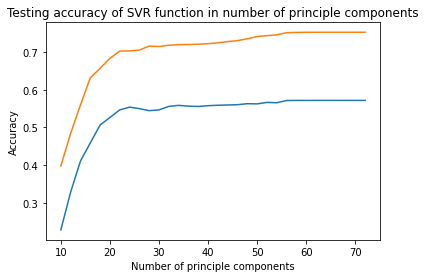

In [ ]:

plt.plot(np.arange(10,74,2),accuracy)
plt.plot(np.arange(10,74,2),train_acc)
plt.title('Testing accuracy of SVR function in number of principle components')
plt.xlabel("Number of principle components")
plt.ylabel("Accuracy");

### Training a Laplacian Ridge Kernel

In [ ]:

model = sklearn.kernel_ridge.KernelRidge(0.1, kernel='laplacian', gamma=0.005)
laplacian = model.fit(X_train_pca, y_train)
print("Scores for Laplacian Ridge Kernel:\n")
print(f"Training Accuracy: {model.score(X_train_pca, y_train)*100:.2f} %")
print(f"Testing Accuracy: {model.score(X_test_pca, y_test)*100:.2f} %")

Scores for Laplacian Ridge Kernel:

Training Accuracy: 86.86 %
Testing Accuracy: 60.34 %


### Training a Tree Regressor 

In [ ]:
clf_tree_regression = sklearn.tree.DecisionTreeRegressor(random_state=random_state)
tree_reg= clf_tree_regression.fit(X_train_pca,y_train)
print("Scores for Tree Regressor:\n")
print(f"Training Accuracy: {clf_tree_regression.score(X_train_pca, y_train)*100:.2f} %")
print(f"Testing Accuracy: {clf_tree_regression.score(X_test_pca, y_test)*100:.2f} %")

Scores for Tree Regressor:

Training Accuracy: 100.00 %
Testing Accuracy: -15.67 %


### Hyperparameter search and model selection

In [ ]:
param_distributions=dict(C=stats.reciprocal(1, 1000),gamma=stats.reciprocal(0.01, 10))
RandomSearchCV=sklearn.model_selection.RandomizedSearchCV(clf,param_distributions,cv=3,n_iter=10,random_state=random_state,verbose=1)


In [ ]:
print(RandomSearchCV)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f998bac59b0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f998bbfacf8>},
                   pre_dispatch='2*n_jobs', random_state=0, refit=True,
                   return_train_score=False, scoring=None, verbose=1)


### Regression Metrics

In [ ]:
predictions = clf.predict(X_test_pca)
("Metrics for evaluating the test data + model :-")
print("")
print(f"Mean absolute error: {sklearn.metrics.mean_absolute_error(y_test,predictions):.1f}")
print(f"Max error: {sklearn.metrics.max_error(y_test,predictions):.1f}")
print(f"R2 score: {sklearn.metrics.r2_score(y_test,predictions):.2f}")


Mean absolute error: 0.8
Max error: 3.5
R2 score: 0.57


Mean absolute error: 0.81
Variance score: 0.57
Median absolute error: 0.68
Mean Gamma deviance: 0.11


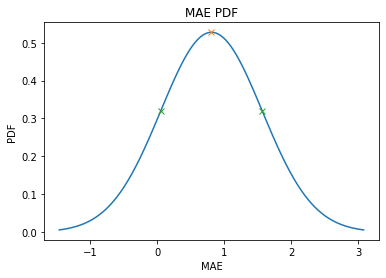

In [ ]:
global mean, variance
mean = sklearn.metrics.mean_absolute_error(y_test,predictions)
variance = sklearn.metrics.explained_variance_score(y_test,predictions)
print(f"Mean absolute error: {mean:.2f}")
print(f"Variance score: {variance:.2f}") # best possible score is 1.0
print(f"Median absolute error: {sklearn.metrics.median_absolute_error(y_test,predictions):.2f}")
print(f"Mean Gamma deviance: {sklearn.metrics.mean_tweedie_deviance(y_test,predictions,power=2):.2f}") # The deviance when power=2 is thus only sensitive to relative errors.
sigma=math.sqrt(variance)
plt.figure()
x = np.linspace(mean - 3*sigma, mean + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mean, sigma))
plt.plot(mean,stats.norm.pdf(mean, mean, sigma),'x')
plt.plot([mean+sigma, mean-sigma],stats.norm.pdf([mean+sigma, mean-sigma], mean, sigma),'x')
plt.title("MAE PDF")
plt.xlabel("MAE")
plt.ylabel("PDF");

### Less Strict Accuracy Measure 

In [ ]:
def measure_accuracy(iconicity_ratings,ground_truths):
  iconicity_ratings = np.array(iconicity_ratings)
  ground_truths = np.array(ground_truths)
  error=0
  for i in range(len(iconicity_ratings)):
    abs_error = abs(ground_truths[i]-iconicity_ratings[i])
    if 0<=abs_error<=mean+np.sqrt(variance) :
      error=error
    else:
      error=error+1

  error_rate= error/len(ground_truths)
  return 1-error_rate 

In [ ]:

print("Accuracy Measures for SVR Model: \n")
print(f"Training Accuracy Measure for a tolerance of {mean:.3f} +- {np.sqrt(variance):.3f} {measure_accuracy(svr.predict(X_train_pca),y_train)*100:.3f}%")
print(f"Testing Accuracy Measure for a tolerance of {mean:.3f} +- {np.sqrt(variance):.3f} {measure_accuracy(svr.predict(X_test_pca),y_test)*100:.3f}%\n")

print("Accuracy Measures for Laplacian Ridge Kernel: \n")
print(f"Training Accuracy Measure for a tolerance of {mean:.3f} +- {np.sqrt(variance):.3f} {measure_accuracy(laplacian.predict(X_train_pca),y_train)*100:.3f}%")
print(f"Testing Accuracy Measure for a tolerance of {mean:.3f} +- {np.sqrt(variance):.3f} {measure_accuracy(laplacian.predict(X_test_pca),y_test)*100:.3f}%")



Accuracy Measures for SVR Model: 

Training Accuracy Measure for a tolerance of 0.811 +- 0.756 93.033%
Testing Accuracy Measure for a tolerance of 0.811 +- 0.756 88.956%

Accuracy Measures for Laplacian Ridge Kernel: 

Training Accuracy Measure for a tolerance of 0.811 +- 0.756 98.596%
Testing Accuracy Measure for a tolerance of 0.811 +- 0.756 90.763%
